preproccessing data visualization and feature engineering

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


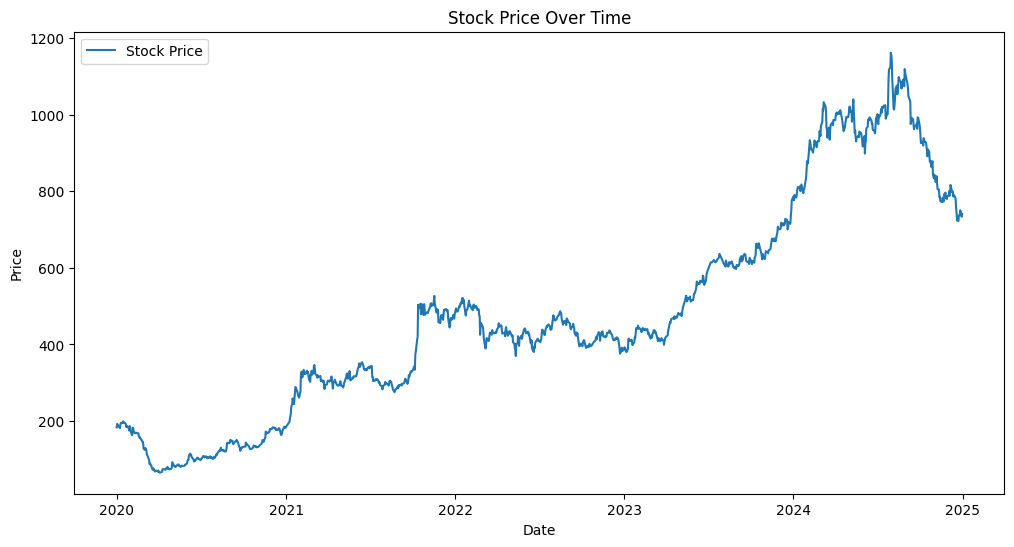

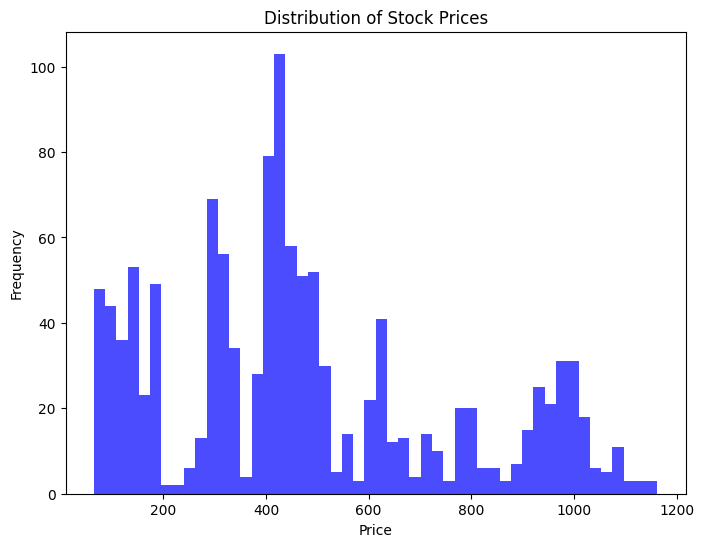

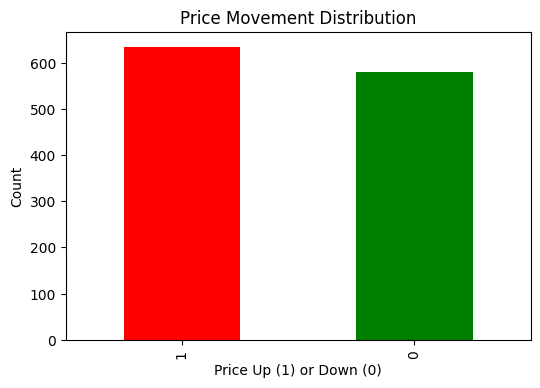

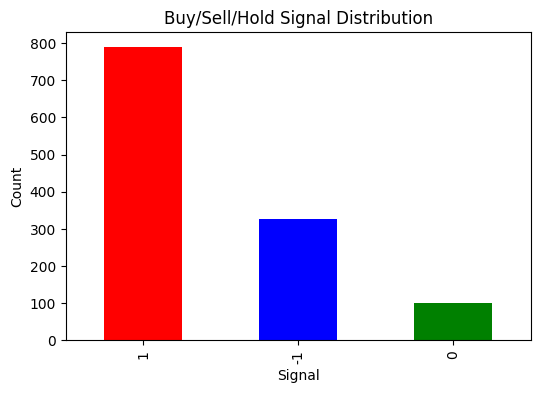

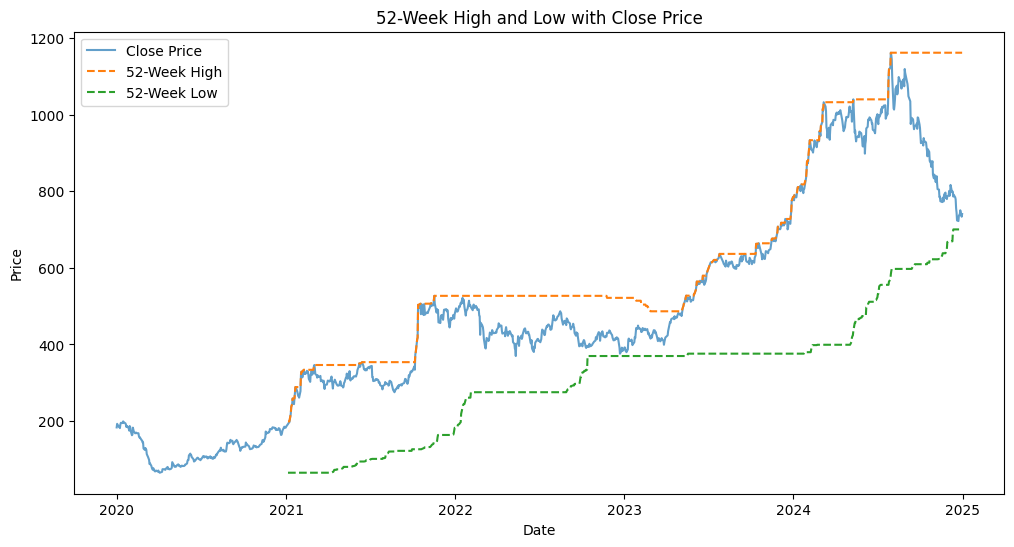

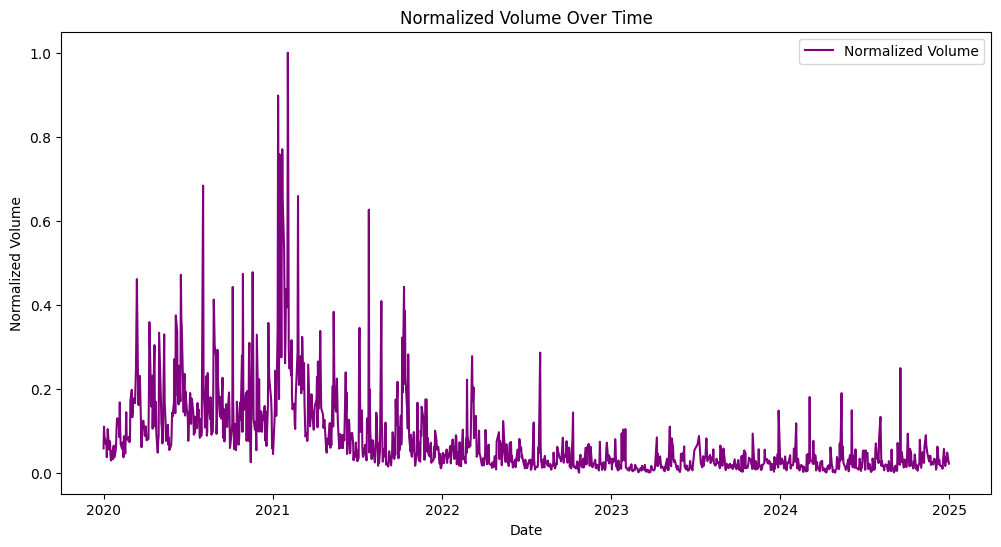

In [1]:
# Install required libraries
!pip install yfinance
!pip install tensorflow

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

# Define functions for preprocessing and analysis
def load_stock_data(ticker, start_date, end_date):
    """Fetch historical stock data using Yahoo Finance API."""
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

def preprocess_data(data):
    """Preprocess stock data."""
    # Handle missing values
    data.dropna(inplace=True)

    # Scale 'Close' prices and 'Volume'
    scaler = MinMaxScaler()
    data['Scaled_Close'] = scaler.fit_transform(data[['Close']])
    data['Scaled_Volume'] = scaler.fit_transform(data[['Volume']])

    # Create binary label for price movement
    data['Price_Up'] = (data['Close'].shift(-1) > data['Close']).astype(int)

    # Calculate short-term (40-day) and long-term (100-day) SMAs
    data['SMA_40'] = data['Close'].rolling(window=40).mean()
    data['SMA_100'] = data['Close'].rolling(window=100).mean()

    # Generate trading signals
    data['Signal'] = 0
    data.loc[data['SMA_40'] > data['SMA_100'], 'Signal'] = 1
    data.loc[data['SMA_40'] < data['SMA_100'], 'Signal'] = -1

    # Calculate 52-week high and low
    data['52_Week_High'] = data['Close'].rolling(window=252).max()
    data['52_Week_Low'] = data['Close'].rolling(window=252).min()

    return data

def visualize_data(data):
    """Perform Exploratory Data Analysis (EDA) with visualizations."""
    # Time Series Plot
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Stock Price')
    plt.title('Stock Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Distribution of Stock Prices
    plt.figure(figsize=(8, 6))
    plt.hist(data['Close'], bins=50, color='blue', alpha=0.7)
    plt.title('Distribution of Stock Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()

    # Binary Price Movement Distribution
    plt.figure(figsize=(6, 4))
    data['Price_Up'].value_counts().plot(kind='bar', color=['red', 'green'])
    plt.title('Price Movement Distribution')
    plt.xlabel('Price Up (1) or Down (0)')
    plt.ylabel('Count')
    plt.show()

    # Buy/Sell/Hold Signal Distribution
    plt.figure(figsize=(6, 4))
    data['Signal'].value_counts().plot(kind='bar', color=['red', 'blue', 'green'])
    plt.title('Buy/Sell/Hold Signal Distribution')
    plt.xlabel('Signal')
    plt.ylabel('Count')
    plt.show()

    # 52-Week High/Low Plot
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7)
    plt.plot(data.index, data['52_Week_High'], label='52-Week High', linestyle='--')
    plt.plot(data.index, data['52_Week_Low'], label='52-Week Low', linestyle='--')
    plt.title('52-Week High and Low with Close Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Normalized Volume Plot
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Scaled_Volume'], label='Normalized Volume', color='purple')
    plt.title('Normalized Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Normalized Volume')
    plt.legend()
    plt.show()

# Main script
if __name__ == "__main__":
    # Specify parameters for Tata Motors data
    ticker = "TATAMOTORS.BO"
    start_date = "2020-01-01"
    end_date = "2025-01-01"

    try:
        # Load and preprocess data
        stock_data = load_stock_data(ticker, start_date, end_date)
        stock_data = preprocess_data(stock_data)

        # Check for critical columns
        if 'Close' not in stock_data.columns or 'Price_Up' not in stock_data.columns:
            raise ValueError("Critical columns are missing after processing.")

        # Perform EDA
        visualize_data(stock_data)

    except Exception as e:
        print(f"An error occurred: {e}")


LSTM stock prediction with and without features

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load stock data
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Preprocessing function without feature engineering
def preprocess_data_basic(data):
    data.dropna(inplace=True)
    scaler = MinMaxScaler()
    data['Scaled_Close'] = scaler.fit_transform(data[['Close']])
    return data[['Scaled_Close']], scaler

# Preprocessing function with feature engineering
def preprocess_data_with_features(data):
    data.dropna(inplace=True)
    scaler = MinMaxScaler()
    data['Scaled_Close'] = scaler.fit_transform(data[['Close']])
    data['SMA_40'] = data['Close'].rolling(window=40).mean()
    data['SMA_100'] = data['Close'].rolling(window=100).mean()
    data['Price_Change'] = data['Close'].pct_change()
    data.fillna(0, inplace=True)

    features = ['Scaled_Close', 'SMA_40', 'SMA_100', 'Price_Change']

    return data[features], scaler

# Convert data into sequences for LSTM
def create_sequences(data, sequence_length):
    sequences, labels = [], []

    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length, 0])  # Always predict only 'Scaled_Close'

    return np.array(sequences), np.array(labels)

# LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)  # Ensure model outputs only one value
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

# Main function
def train_and_evaluate_lstm(ticker, start_date, end_date, sequence_length=50, use_features=False):
    data = load_stock_data(ticker, start_date, end_date)

    if use_features:
        data, scaler = preprocess_data_with_features(data)
    else:
        data, scaler = preprocess_data_basic(data)

    X, y = create_sequences(data.values, sequence_length)

    # Train-test split (80% training, 20% testing)
    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)

    print(f'MSE: {mse}, RMSE: {rmse}')

    return model, scaler, mse, rmse

# Run models
start_date = '2020-01-01'
end_date = '2025-01-01'
ticker = 'TATAMOTORS.BO'

print("Training LSTM without feature engineering...")
lstm_basic, scaler_basic, mse_basic, rmse_basic = train_and_evaluate_lstm(ticker, start_date, end_date, use_features=False)

print("Training LSTM with feature engineering...")
lstm_with_features, scaler_features, mse_features, rmse_features = train_and_evaluate_lstm(ticker, start_date, end_date, use_features=True)

print(f"LSTM without Features -> MSE: {mse_basic}, RMSE: {rmse_basic}")
print(f"LSTM with Features -> MSE: {mse_features}, RMSE: {rmse_features}")


[*********************100%***********************]  1 of 1 completed

Training LSTM without feature engineering...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - loss: 0.0385 - val_loss: 0.0046
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 9.1540e-04 - val_loss: 0.0033
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss:

[*********************100%***********************]  1 of 1 completed

MSE: 0.0015349402265609354, RMSE: 0.03917831321740301
Training LSTM with feature engineering...
Epoch 1/20



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0407 - val_loss: 0.1989
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0114 - val_loss: 0.1520
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0092 - val_loss: 0.2140
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0083 - val_loss: 0.1625
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0067 - val_loss: 0.1429
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0049 - val_loss: 0.1532
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0042 - val_loss: 0.0917
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0036 - val_loss: 0.1242
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0050 - val_loss: 0.1064
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0031 - val_loss: 0.0920
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0024 - val_loss: 0.0880
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0027 - val_l

LSTM comparitive modeling

[*********************100%***********************]  1 of 1 completed

Training LSTM without feature engineering...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


[*********************100%***********************]  1 of 1 completed

Training LSTM with feature engineering...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
LSTM without Features -> RMSE: 0.03488912291700106
LSTM with Features -> RMSE: 0.3575452317064137


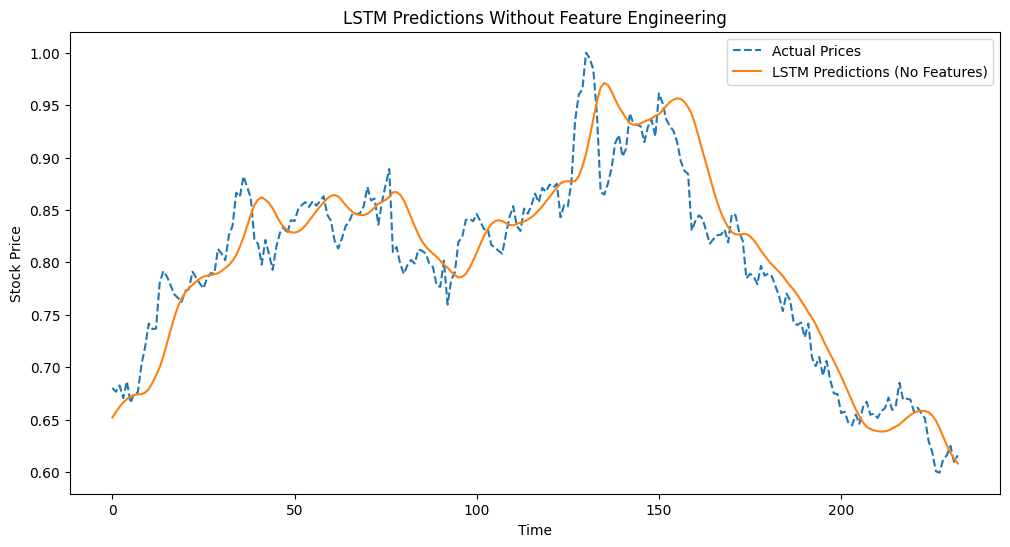

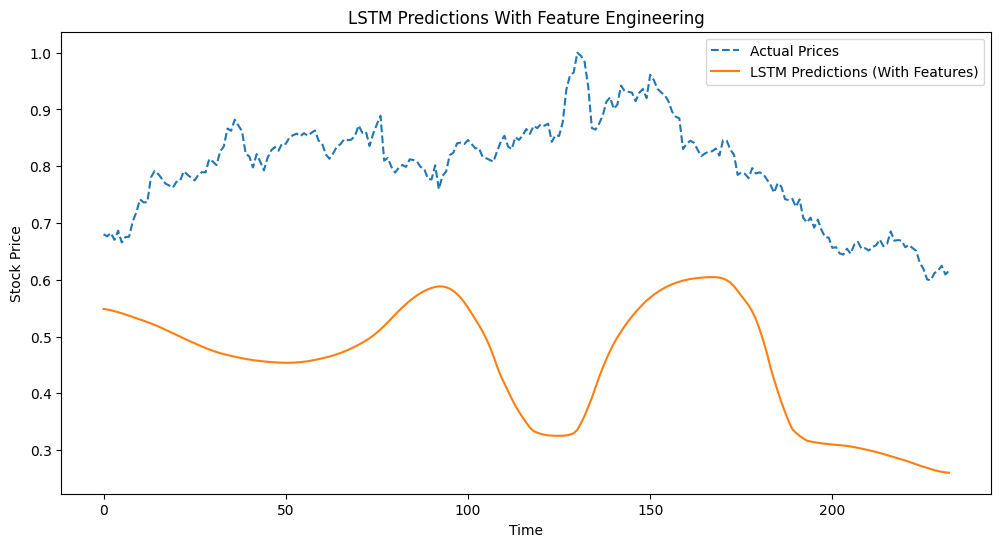

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load stock data
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Preprocessing function without feature engineering
def preprocess_data_basic(data):
    data.dropna(inplace=True)
    scaler = MinMaxScaler()
    data['Scaled_Close'] = scaler.fit_transform(data[['Close']])
    return data[['Scaled_Close']], scaler

# Preprocessing function with feature engineering
def preprocess_data_with_features(data):
    data.dropna(inplace=True)
    scaler = MinMaxScaler()
    data['Scaled_Close'] = scaler.fit_transform(data[['Close']])
    data['SMA_40'] = data['Close'].rolling(window=40).mean()
    data['SMA_100'] = data['Close'].rolling(window=100).mean()
    data['Price_Change'] = data['Close'].pct_change()
    data.fillna(0, inplace=True)

    features = ['Scaled_Close', 'SMA_40', 'SMA_100', 'Price_Change']

    return data[features], scaler

# Convert data into sequences for LSTM
def create_sequences(data, sequence_length):
    sequences, labels = [], []

    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length, 0])  # Always predict only 'Scaled_Close'

    return np.array(sequences), np.array(labels)

# LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)  # Ensure model outputs only one value
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

# Train and Evaluate LSTM Model
def train_and_evaluate_lstm(ticker, start_date, end_date, sequence_length=50, use_features=False):
    data = load_stock_data(ticker, start_date, end_date)

    if use_features:
        data, scaler = preprocess_data_with_features(data)
    else:
        data, scaler = preprocess_data_basic(data)

    X, y = create_sequences(data.values, sequence_length)

    # Train-test split (80% training, 20% testing)
    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)

    return model, scaler, mse, rmse, y_test, predictions

# Define stock and time range
start_date = '2020-01-01'
end_date = '2025-01-01'
ticker = 'TATAMOTORS.BO'

# Train LSTM without feature engineering
print("Training LSTM without feature engineering...")
lstm_basic, scaler_basic, mse_basic, rmse_basic, y_test_basic, predictions_basic = train_and_evaluate_lstm(
    ticker, start_date, end_date, use_features=False)

# Train LSTM with feature engineering
print("Training LSTM with feature engineering...")
lstm_with_features, scaler_features, mse_features, rmse_features, y_test_features, predictions_features = train_and_evaluate_lstm(
    ticker, start_date, end_date, use_features=True)

# Print RMSE values
print(f"LSTM without Features -> RMSE: {rmse_basic}")
print(f"LSTM with Features -> RMSE: {rmse_features}")

# Plot Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(y_test_basic, label="Actual Prices", linestyle="dashed")
plt.plot(predictions_basic, label="LSTM Predictions (No Features)")
plt.title("LSTM Predictions Without Feature Engineering")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_features, label="Actual Prices", linestyle="dashed")
plt.plot(predictions_features, label="LSTM Predictions (With Features)")
plt.title("LSTM Predictions With Feature Engineering")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


Hybrid RF and LSTM model

[*********************100%***********************]  1 of 1 completed
<ipython-input-4-deaae05fa3e8>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = scaler.fit_transform(data[features])
<ipython-input-4-deaae05fa3e8>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['Close']] = close_scaler.fit_transform(data[['Close']])  # Separate scaler for Close prices


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0392 - mse: 0.0392
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mse: 0.0074
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mse: 0.0031
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mse: 0.0026
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mse: 0.0020
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mse: 0.0015
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - mse: 0.0011
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4661e-04 - mse: 7.4661e-04
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3300e-04 - mse: 5.3300e-04
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4450e-04 - mse: 5.4450e-04
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8675e-04 - mse: 4.8675e-04
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2280e-04 - mse: 4.2280e-04
Epoch 13/20
28/28 ━

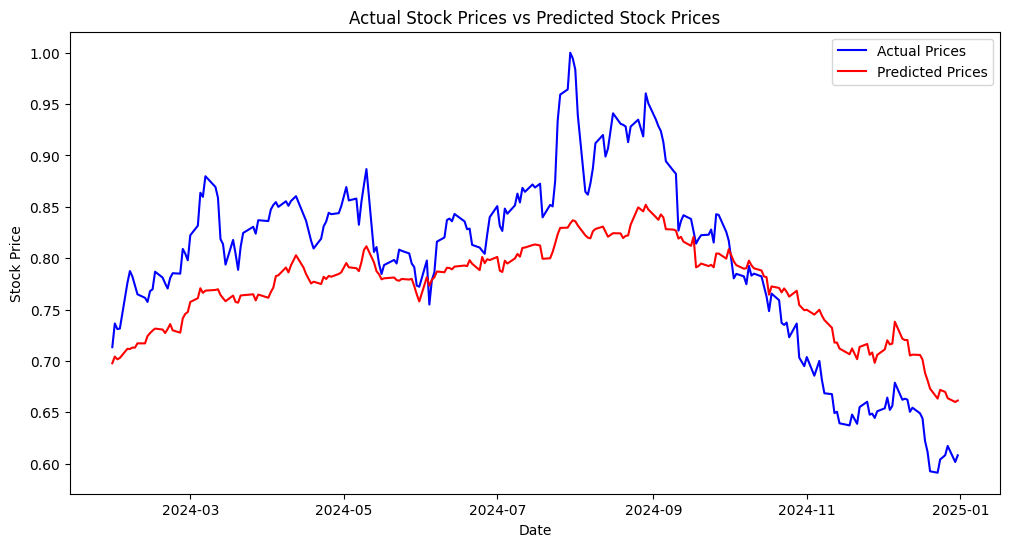

Hybrid Model Execution Completed!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load Stock Data
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Add Technical Indicators without external libraries
def add_technical_indicators(data):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    data['SMA_40'] = data['Close'].rolling(window=40).mean()
    data['SMA_100'] = data['Close'].rolling(window=100).mean()
    data['Upper_Band'] = data['Close'].rolling(20).mean() + 2 * data['Close'].rolling(20).std()
    data['Lower_Band'] = data['Close'].rolling(20).mean() - 2 * data['Close'].rolling(20).std()
    return data.dropna()

# Normalize Data
def preprocess_data(data):
    scaler = MinMaxScaler()
    close_scaler = MinMaxScaler()
    features = ['Close', 'Volume', 'RSI', 'Upper_Band', 'Lower_Band', 'SMA_40', 'SMA_100']
    data[features] = scaler.fit_transform(data[features])
    data[['Close']] = close_scaler.fit_transform(data[['Close']])  # Separate scaler for Close prices
    return data, scaler, close_scaler

# Train Random Forest Regressor Model
def train_random_forest(X_train, y_train):
    rf_model = RandomForestRegressor(n_estimators=100)
    rf_model.fit(X_train, y_train)
    return rf_model

# Train LSTM Model
def train_lstm(X_train, y_train):
    X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
    lstm_model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
        LSTM(50, return_sequences=False),
        Dense(1)
    ])
    lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)
    return lstm_model

# Visualize Predictions vs Actual Prices
def visualize_predictions(y_test, final_preds, actual_prices):
    plt.figure(figsize=(12,6))
    plt.plot(actual_prices.index[-len(y_test):], actual_prices[-len(y_test):], label="Actual Prices", color='blue')
    plt.plot(actual_prices.index[-len(y_test):], final_preds, label="Predicted Prices", color='red')
    plt.title("Actual Stock Prices vs Predicted Stock Prices")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

# Main Execution
if __name__ == "__main__":
    ticker = "TATAMOTORS.BO"
    start_date = "2020-01-01"
    end_date = "2025-01-01"

    stock_data = load_stock_data(ticker, start_date, end_date)
    stock_data = add_technical_indicators(stock_data)
    stock_data, scaler, close_scaler = preprocess_data(stock_data)

    features = ['Close', 'Volume', 'RSI', 'Upper_Band', 'Lower_Band', 'SMA_40', 'SMA_100']
    X = stock_data[features]
    y = stock_data[['Close']]

    train_size = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    rf_model = train_random_forest(X_train, y_train.values.ravel())
    lstm_model = train_lstm(X_train, y_train)

    X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))
    rf_preds = rf_model.predict(X_test).reshape(-1, 1)
    lstm_preds = lstm_model.predict(X_test_lstm).reshape(-1, 1)

    final_preds = (rf_preds + lstm_preds) / 2
    final_preds = close_scaler.inverse_transform(final_preds)  # Properly inverse transform only Close price

    # Calculate RMSE and MSE
    mse = mean_squared_error(y_test, final_preds)
    rmse = np.sqrt(mse)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Visualize the actual stock prices vs predicted prices
    visualize_predictions(y_test, final_preds, stock_data['Close'])

    print("Hybrid Model Execution Completed!")

Hybrid ARIMA lstm rf

[*********************100%***********************]  1 of 1 completed


ADF Statistic: -1.5510847912970032
p-value: 0.5081062837721981


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 191704.8750
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 165751.6875
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 68173.2266
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6252.5957
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 218.1646
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 105.4864
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 90.9890
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87.0916
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 90.7236
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102.4710
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 89.8029
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 95.9692
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 91.1017
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102.1475
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

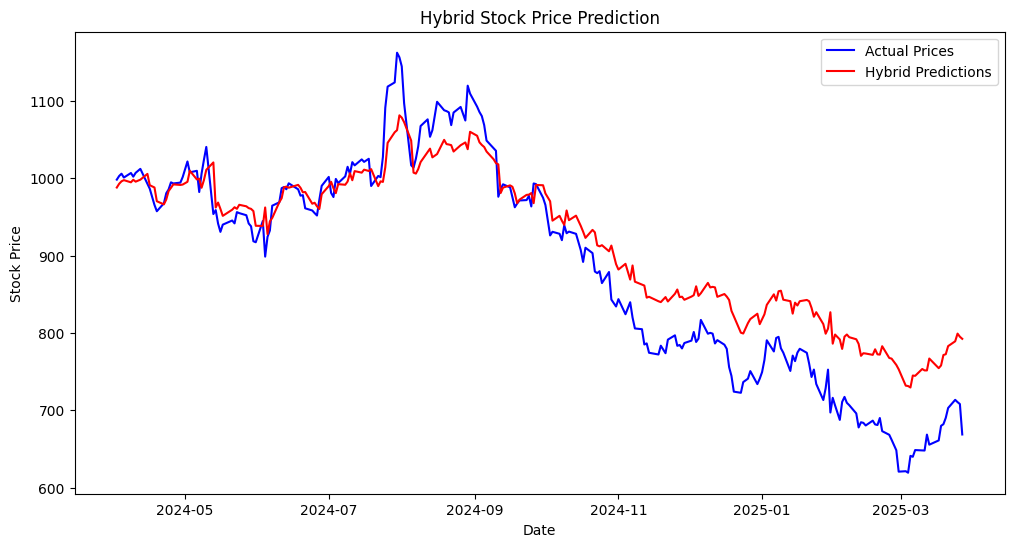

In [5]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import yfinance as yf

# --- Step 1: Data Collection ---

def fetch_stock_data(stock_ticker, start_date, end_date):
    """
    Fetch historical stock data from Yahoo Finance.
    """
    stock_data = yf.download(stock_ticker, start=start_date, end=end_date)
    stock_data.reset_index(inplace=True)
    stock_data.columns = [col[0] if isinstance(col, tuple) else col for col in stock_data.columns]
    return stock_data

# --- Step 2: Data Preprocessing ---
def preprocess_data(stock_data):
    """
    Preprocess stock data for modeling.
    """
    stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.tz_localize(None)

    # Test for stationarity and differencing if needed
    if not test_stationarity(stock_data['Close']):
        stock_data['Close_Diff'] = stock_data['Close'].diff().dropna()

    # Scaling features
    scaler = MinMaxScaler()
    stock_data['Lag_Close'] = scaler.fit_transform(
        stock_data['Close'].values.reshape(-1, 1)
    )

    # Create lag features
    stock_data['Lag_Close'] = stock_data['Close'].shift(1)
    stock_data.dropna(inplace=True)
    return stock_data

# Test for stationarity
def test_stationarity(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    return result[1] < 0.05

# --- Step 3: Feature Engineering ---
features = ['Lag_Close']
target = 'Close'

# --- Step 4: Model Development ---
def arima_forecast(train, test):
    model = ARIMA(train['Close'], order=(5, 1, 0))
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))
    return predictions

def lstm_forecast(train, test):
    X_train = np.array(train[features]).reshape((train.shape[0], 1, len(features)))
    y_train = train[target]

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(1, len(features))))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

    X_test = np.array(test[features]).reshape((test.shape[0], 1, len(features)))
    predictions = model.predict(X_test)
    return predictions.flatten()

def random_forest_forecast(train, test):
    model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
    model.fit(train[features], train[target])
    predictions = model.predict(test[features])
    return predictions

# Hybrid model
def hybrid_predictions(arima_pred, lstm_pred, rf_pred, weights):
    return (
        weights['arima'] * arima_pred +
        weights['lstm'] * lstm_pred +
        weights['rf'] * rf_pred
    )

# --- Main Function ---
def main():
    stock_ticker = "TATAMOTORS.BO"
    start_date = datetime.now() - timedelta(days=1825)
    end_date = datetime.now()

    stock_data = fetch_stock_data(stock_ticker, start_date, end_date)
    processed_data = preprocess_data(stock_data)

    train_size = int(len(processed_data) * 0.8)
    train, test = processed_data.iloc[:train_size], processed_data.iloc[train_size:]

    # Individual model predictions
    arima_pred = arima_forecast(train, test)
    lstm_pred = lstm_forecast(train, test)
    rf_pred = random_forest_forecast(train, test)

    # Hybrid predictions
    weights = {'arima': 0.3, 'lstm': 0.5, 'rf': 0.2}
    final_pred = hybrid_predictions(arima_pred, lstm_pred, rf_pred, weights)

    # Evaluation
    mse = mean_squared_error(test[target], final_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse}")

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(test['Date'], test[target], label='Actual Prices', color='blue')
    plt.plot(test['Date'], final_pred, label='Hybrid Predictions', color='red')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Hybrid Stock Price Prediction')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
